In [2]:
import pandas as pd
import numpy as np
import yfinance as yfin
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from statsmodels.tsa.stattools import adfuller

In [3]:
def verificarEstacionariedade(df):
    resultado = adfuller(df['Adj Close'])
    print('Estatísticas ADF:', resultado[0])
    print('Valor p:', resultado[1])
    print('Número de lags utilizados:', resultado[2])
    print('Número de observações utilizadas para ADF:', resultado[3])
    print('Valores críticos:')
    for key, value in resultado[4].items():
        print(f'\t{key}: {value}')
    if resultado[1] <= 0.05:
        print("A série é estacionária (rejeitamos a hipótese nula).")
    else:
        print("A série não é estacionária (não rejeitamos a hipótese nula).")


In [4]:
def carregarDados(ticker, data_inicio, data_fim):
    df = yfin.download(tickers=ticker, start=data_inicio, end=data_fim)
    return df

In [5]:
def normalizar(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df['Adj Close'].values.reshape(-1, 1))
    return scaled_data, scaler

In [6]:
def prepararDados(df, days):
    x_train = []
    y_train = []
    for i in range(days, len(df)):
        x_train.append(df[i-days:i])
        y_train.append(df[i])
    return np.array(x_train), np.array(y_train)


In [7]:
def modeloLSTM(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    return model

In [8]:
def treinarModelo(model, x_train, y_train, epochs=25, batch_size=32):
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

In [9]:
def avaliarTreino(model, x_train, df, scaler, days):
    predicted_train = model.predict(x_train)
    predicted_train = scaler.inverse_transform(predicted_train)

    actual_train = df['Adj Close'].values
    mae_train = mean_absolute_error(actual_train[days:], predicted_train)
    mse_train = mean_squared_error(actual_train[days:], predicted_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(actual_train[days:], predicted_train)

    return mae_train, mse_train, rmse_train, r2_train, actual_train, predicted_train

In [10]:
def prepararDadosTeste(total_dataset, df_teste, scaler, days):
    model_inputs = total_dataset[len(total_dataset) - len(df_teste) - days:].values
    model_inputs = model_inputs.reshape(-1, 1)
    model_inputs = scaler.transform(model_inputs)

    x_test = []
    for i in range(days, len(model_inputs)):
        x_test.append(model_inputs[i-days:i, 0])
    
    x_test = np.array(x_test)
    return np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [11]:
def avaliarTeste(model, x_test, df_teste, scaler, days):
    predicted_test = model.predict(x_test)
    predicted_test = scaler.inverse_transform(predicted_test)
    
    actual_test = df_teste['Adj Close'].values
    
    mae = mean_absolute_error(actual_test, predicted_test)
    mse = mean_squared_error(actual_test, predicted_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_test, predicted_test)
    
    return mae, mse, rmse, r2, actual_test, predicted_test


In [12]:
def plotarResultados2(df_treino, predicted_train, actual_test, predicted_test, days, ticker):
    plt.figure(figsize=(14, 7))

    plt.plot(df_treino['Adj Close'].values, color='blue', label=f'Dados de Treinamento da {ticker}')
    
    #plt.plot(range(days, days + len(predicted_train)), predicted_train, color='red', label=f'Previsão do Treinamento {ticker}')
    
    plt.plot(range(len(df_treino), len(df_treino) + len(actual_test)), actual_test, color='black', label=f'Preços Reais da {ticker}')
    
    #plt.plot(range(len(df_treino), len(df_treino) + len(predicted_test)), predicted_test, color='green', label=f'Previsão do Teste da {ticker}')

    plt.title(f'{ticker} - Janela: {days} dias')
    plt.xlabel('Tempo')
    plt.ylabel(f'Preço de {ticker}')
    
    plt.legend()
    
    plt.savefig(f'prediction_plot_{days}_days.png')
    plt.show()


In [13]:
def plotarResultados1(df_treino, predicted_train, actual_test, predicted_test, days, ticker):
    plt.figure(figsize=(14, 7))

    #plt.plot(df_treino['Adj Close'].values, color='blue', label=f'Dados de Treinamento da {ticker}')
    
    plt.plot(range(days, days + len(predicted_train)), predicted_train, color='red', label=f'Previsão do Treinamento {ticker}')
    
    #plt.plot(range(len(df_treino), len(df_treino) + len(actual_test)), actual_test, color='black', label=f'Preços Reais da {ticker}')
    
    plt.plot(range(len(df_treino), len(df_treino) + len(predicted_test)), predicted_test, color='green', label=f'Previsão do Teste da {ticker}')

    plt.title(f'{ticker} - Janela: {days} dias')
    plt.xlabel('Tempo')
    plt.ylabel(f'Preço de {ticker}')
    
    plt.legend()
    
    plt.savefig(f'prediction_plot_{days}_days.png')
    plt.show()


In [14]:
def executarModelo(ticket, data, max_days=21):
    all_results = []

    scaled_data, scaler = normalizar(data)

    for days in range(1, max_days):
        x_train, y_train = prepararDados(scaled_data, days)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        model = modeloLSTM((x_train.shape[1], 1))
        model = treinarModelo(model, x_train, y_train)

        mae_train, mse_train, rmse_train, r2_train, actual_train, predicted_train = avaliarTreino(model, x_train, data, scaler, days)

        print(actual_train[:5])
        print(predicted_train[:5])

        df_teste = carregarDados(ticket, '2021-01-01', '2024-01-01')
        df_teste_diff = df_teste.diff().dropna()
        total_dataset = pd.concat((data['Adj Close'], df_teste_diff['Adj Close']), axis=0)

        x_test = prepararDadosTeste(total_dataset, df_teste_diff, scaler, days)


        mae, mse, rmse, r2, actual_test, predicted_test = avaliarTeste(model, x_test, df_teste_diff, scaler, days)

        predicted_test = predicted_test.ravel()
        print(actual_test[:5])
        print(predicted_test[:5])

        plotarResultados1(data, predicted_train, actual_test, predicted_test, days, ticket)
        plotarResultados2(data, predicted_train, actual_test, predicted_test, days, ticket)

        all_results.append({
            'Days': days,
            'MAE_Train': mae_train,
            'MSE_Train': mse_train,
            'RMSE_Train': rmse_train,
            'R²_Train': r2_train,
            'MAE_Test': mae,
            'MSE_Test': mse,
            'RMSE_Test': rmse,
            'R²_Test': r2
        })

    all_results_df = pd.DataFrame(all_results)
    all_results_df.to_csv('model_performance_all_days.csv', index=False)


In [15]:
ticket = 'PETR4.SA'
data = carregarDados(ticket, '2005-01-01', '2021-01-01')
verificarEstacionariedade(data)
dataDiff = data.diff().dropna()
dataLog = np.log(data)
verificarEstacionariedade(dataDiff)
verificarEstacionariedade(dataLog)

[*********************100%%**********************]  1 of 1 completed
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Estatísticas ADF: -2.6589820560981994
Valor p: 0.08140905396168496
Número de lags utilizados: 12
Número de observações utilizadas para ADF: 3964
Valores críticos:
	1%: -3.432000741590981
	5%: -2.862269407331276
	10%: -2.567158271601324
A série não é estacionária (não rejeitamos a hipótese nula).
Estatísticas ADF: -17.66070420447968
Valor p: 3.683294207063361e-30
Número de lags utilizados: 11
Número de observações utilizadas para ADF: 3964
Valores críticos:
	1%: -3.432000741590981
	5%: -2.862269407331276
	10%: -2.567158271601324
A série é estacionária (rejeitamos a hipótese nula).
Estatísticas ADF: -2.7900598491710675
Valor p: 0.0597077362289047
Número de lags utilizados: 10
Número de observações utilizadas para ADF: 3966
Valores críticos:
	1%: -3.4319999086046633
	5%: -2.8622690393645924
	10%: -2.5671580757111188
A série não é estacionária (não rejeitamos a hipótese nula).


### Próximos passos:

- Corrigir questão da diferenciação
- Fechar experimentos de definição do tamanho da janela com o k-fold
- Aplicar o melhor tamanho de janela no conjunto de testes (treina com todo o treinamento)
- Foco no relatório com revisão da literatura.

Epoch 1/25


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2023
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Epoch 9/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Epoch 10/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0041
Epoch 11/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036
Epoch 12/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035
Epoch 13/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036
Epoch 14/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036
Epoch 15/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036


[*********************100%%**********************]  1 of 1 completed

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[ 0.39011383  0.02071381  0.31070995  0.04142761 -0.08976078]
[-0.00744606 -0.0060996  -0.00745861 -0.00639163 -0.00738235]


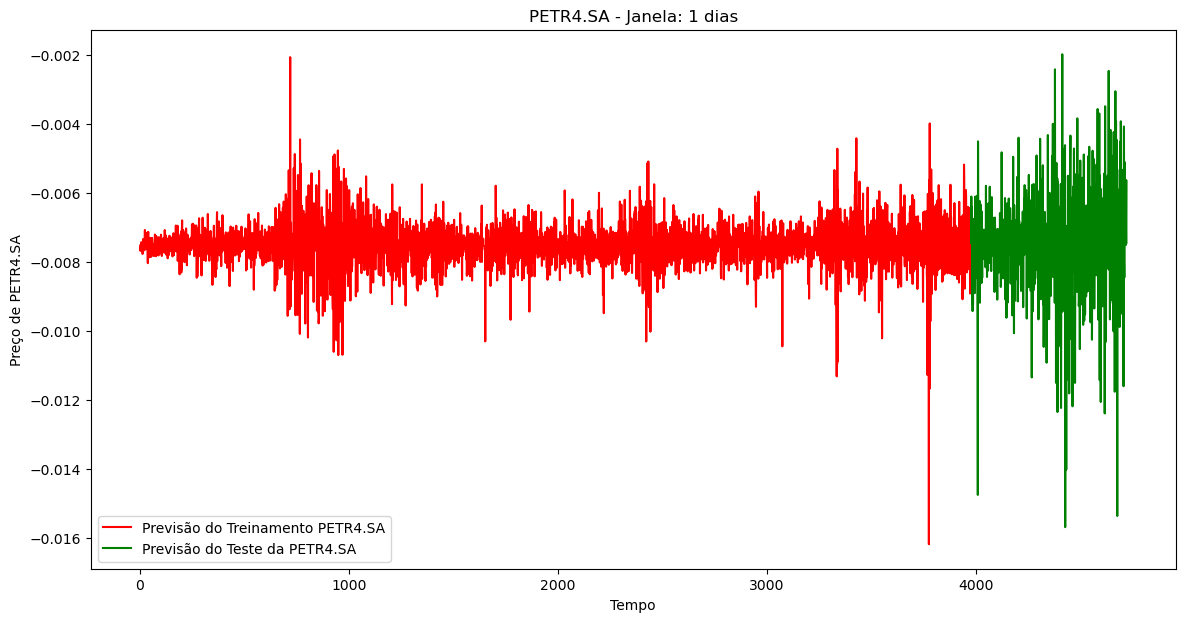

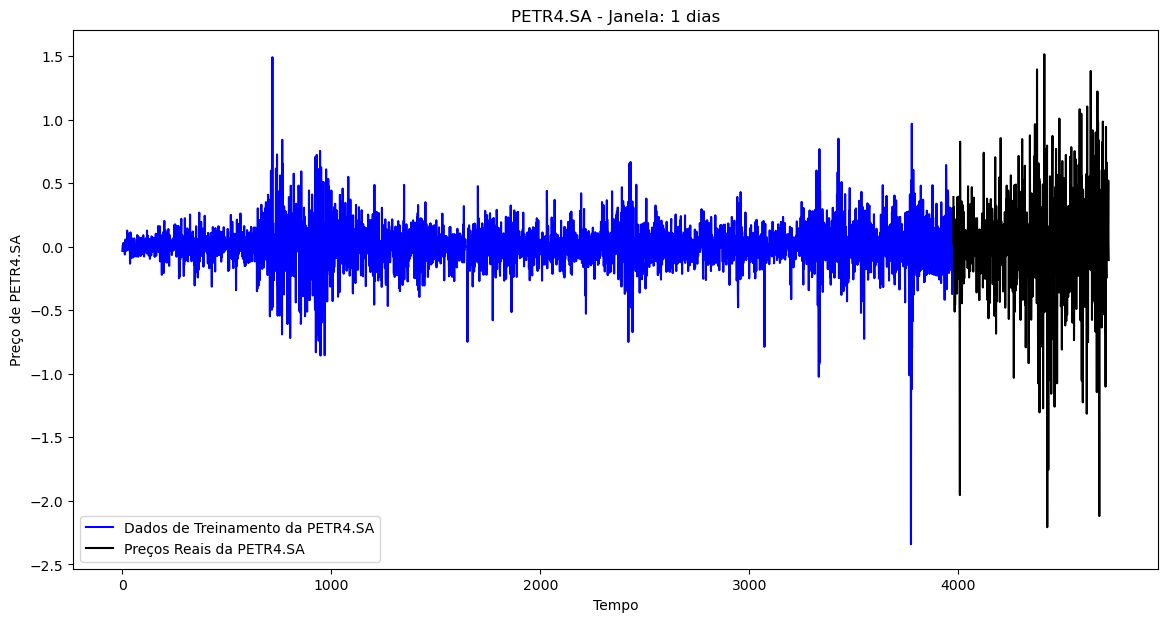

Epoch 1/25


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [16]:
executarModelo(ticket, dataDiff)

### Planejamento:

- Resolver a questão da diferenciação da série temporal;
- Baixou os dados até 2021 → usando como treinamento e validação
    - Baixará de 2022 a 2024 para conjunto de teste.
- 5-fold com janelas de entrada entre 1 e 20:
    - Está usando o TimeSeries split
    - Média e o desvio-padrão de MSE, MAE, RMSE, R2
    - Ajuste de hiperparâmetros? → Procurar bibliotecas para fazer isso.
- Ajustar hiperparâmetros completos agora (incluídos atrasos de entrada) para as séries de valor d
- Ajustar hiperparâmetros completos agora (incluídos atrasos de entrada) para as séries de valor de fechamento
    - Com os indicadores talvez verificar apenas hiperparâmetros da estrutura da rede.
- Indicadores econômicos:
    - Selecionar quais vai utilizar:
        - Identificar opções e de onde baixar ou como calcular.
        - Pré-selecionar com matriz de correlação.
        - Depois verifica experimentalmente.
            - Comparar série pura com série pura + todos os indicadores ao mesm
- Depois verifica experimentalmente.
    - Comparar série pura com série pura + todos os indicadores ao mesmo tempo.
- Estratégia de investimento.
### Próximos passos:

- Enviar prestações de contas;
- Reuniões: livres às tardes → me mandará um e-mail após as férias para agendarmos;